In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Ler a base

In [3]:
df = pd.read_csv('heart_2020_cleaned.csv')

## EDA e Considerações

In [4]:
df_cont = df.select_dtypes('number')
df_cont

,BMI,PhysicalHealth,MentalHealth,SleepTime
0,16.60,3.0,30.0,5.0
1,20.34,0.0,0.0,7.0
2,26.58,20.0,30.0,8.0
3,24.21,0.0,0.0,6.0
4,23.71,28.0,0.0,8.0
...,...,...,...,...
319790,27.41,7.0,0.0,6.0
319791,29.84,0.0,0.0,5.0
319792,24.24,0.0,0.0,6.0
319793,32.81,0.0,0.0,12.0


## Variáveis contínuas

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


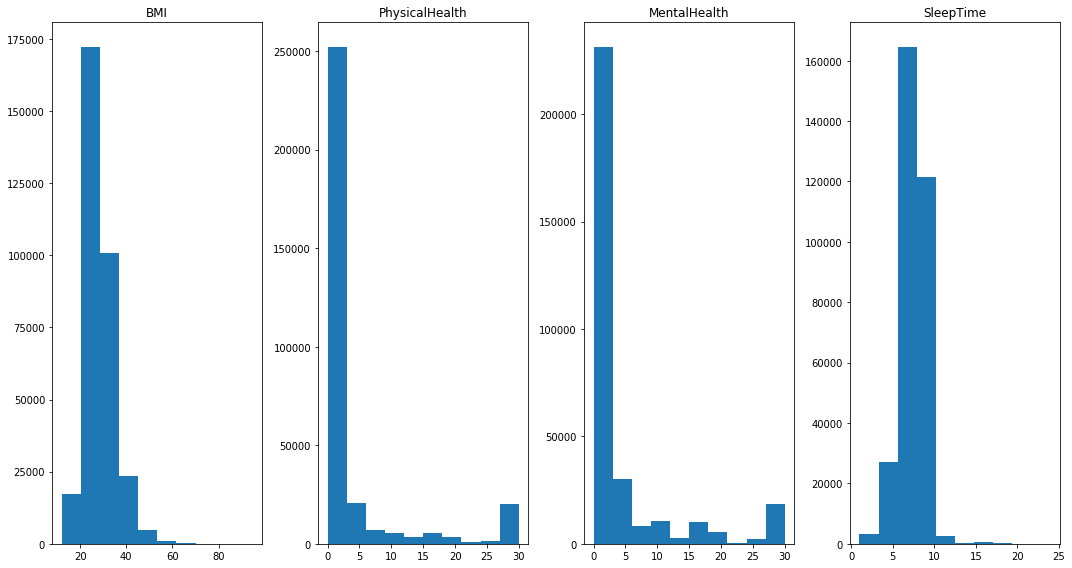

In [5]:
fig, ax = plt.subplots(1, 4,tight_layout=True)


#Body Mass Index (BMI)
#MentalHealth: Thinking about your mental health, for how many days during the past 30 days was your mental health not good?
#PhysicalHealth: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 was not good?
#SleepTime: On average, how many hours of sleep do you get in a 24-hour period?

for i in range(4):
    ax[i].hist(df_cont.iloc[:,i])
    ax[i].set_title(df_cont.columns[i])

fig.set_size_inches(15., 8.)

df_cont.describe()


## Variáveis Categoricas

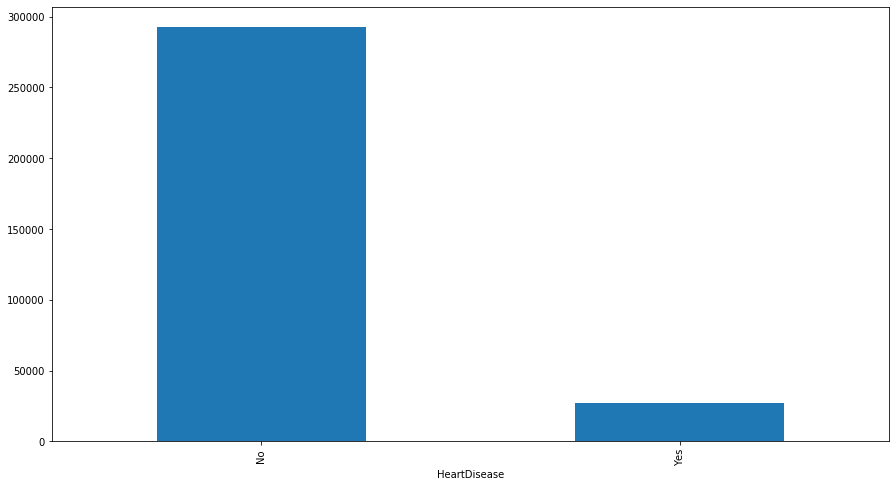

In [6]:
df_disc = df.select_dtypes('object')
''
df_disc.groupby('HeartDisease').count().iloc[:,1].plot(kind='bar',figsize=(15, 8))

# Preparação

#### Os dados já vieram tratados e as features são boas, então aparentemente não há necessidade de fazer engenharia.

In [7]:
y = df.iloc[:,0]
x = df.iloc[:,1:]

In [8]:
#Transformação das variaveis discretas binárias e não binárias.

x_cat = x.select_dtypes(include=['object'])
cat_cols = x_cat.nunique()
binary = cat_cols[cat_cols <= 2]
not_binary = cat_cols[cat_cols > 2]
binary = binary.index.to_list()
not_binary = not_binary.index.to_list()

In [9]:

to_binary = {'Yes' : 1,'No': 0, 'Female':1,'Male':0}
x[binary] = x[binary].replace(to_binary)
x = pd.get_dummies(x,columns=not_binary)
y = y.replace(to_binary)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

In [11]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(C=1.0, max_iter=1000)
lgr.fit(X_train,y_train)


LogisticRegression(max_iter=1000)

In [12]:
#Resultados estão bons, porém, vamos fazer um sanity check...
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test,lgr.predict(X_test)))
confusion_matrix(y_test,lgr.predict(X_test))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     87710
           1       0.53      0.10      0.17      8229

    accuracy                           0.92     95939
   macro avg       0.73      0.55      0.56     95939
weighted avg       0.89      0.92      0.89     95939



array([[86973,   737],
       [ 7390,   839]], dtype=int64)

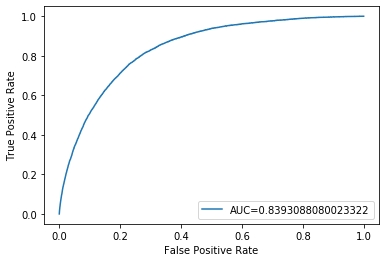

In [13]:
from sklearn import metrics
y_test_roc = y_test.to_numpy().reshape(1,-1)
fpr, tpr, thresholds = metrics.roc_curve(np.squeeze(y_test_roc),np.squeeze(lgr.predict_proba(X_test)[:,1].reshape(1,-1)))

auc = metrics.roc_auc_score(np.squeeze(y_test_roc),np.squeeze(lgr.predict_proba(X_test)[:,1].reshape(1,-1)))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [14]:
from sklearn.dummy import DummyClassifier

#Devido ao grande desbalanceamento de classe, o dummy classifier encontrou um resultado parecido com a regressão logistica. Vamos tentar tratar isso com técnicas de balanceamento.

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_test, y_test)

print(classification_report(y_test,dummy_clf.predict(X_test)))

print(confusion_matrix(y_test,dummy_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     87710
           1       0.00      0.00      0.00      8229

    accuracy                           0.91     95939
   macro avg       0.46      0.50      0.48     95939
weighted avg       0.84      0.91      0.87     95939

[[87710     0]
 [ 8229     0]]


C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [16]:
rus = RandomUnderSampler(sampling_strategy=0.5)
X_over, y_over = rus.fit_resample(x, y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.30)
lgr.fit(X_train,y_train)

print(classification_report(y_test,lgr.predict(X_test)))

confusion_matrix(y_test,lgr.predict(X_test))


              precision    recall  f1-score   support

           0       0.80      0.87      0.84     16382
           1       0.69      0.57      0.63      8254

    accuracy                           0.77     24636
   macro avg       0.75      0.72      0.73     24636
weighted avg       0.77      0.77      0.77     24636



array([[14269,  2113],
       [ 3513,  4741]], dtype=int64)

In [18]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)

print(classification_report(y_test,dummy_clf.predict(X_test)))

print(confusion_matrix(y_test,dummy_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      1.00      0.80     16382
           1       0.00      0.00      0.00      8254

    accuracy                           0.66     24636
   macro avg       0.33      0.50      0.40     24636
weighted avg       0.44      0.66      0.53     24636

[[16382     0]
 [ 8254     0]]


C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


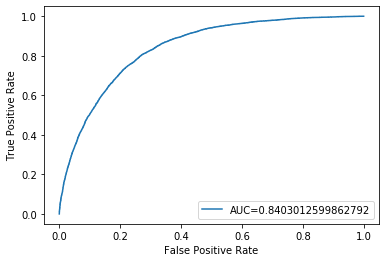

In [21]:
from sklearn import metrics
y_test_roc = y_test.to_numpy().reshape(1,-1)
fpr, tpr, thresholds = metrics.roc_curve(np.squeeze(y_test_roc),np.squeeze(lgr.predict_proba(X_test)[:,1].reshape(1,-1)))

auc = metrics.roc_auc_score(np.squeeze(y_test_roc),np.squeeze(lgr.predict_proba(X_test)[:,1].reshape(1,-1)))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

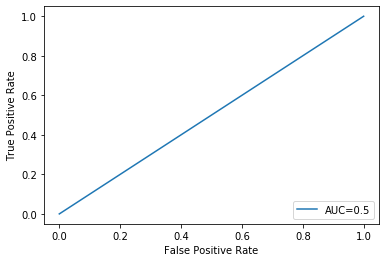

In [20]:
y_test_roc = y_test.to_numpy().reshape(1,-1)
fpr, tpr, thresholds = metrics.roc_curve(np.squeeze(y_test_roc),np.squeeze(dummy_clf.predict_proba(X_test)[:,1].reshape(1,-1)))

auc = metrics.roc_auc_score(np.squeeze(y_test_roc),np.squeeze(dummy_clf.predict_proba(X_test)[:,1].reshape(1,-1)))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [23]:
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [39]:
input_d, output_d = X_test.shape[1], y_test.to_numpy().reshape(1,-1).shape[1]

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 500 == 0:
            print("The average loss for epoch {} is {:7.2f}".format( epoch, logs["loss"]))

nn = tf.keras.Sequential()
nn.add(tf.keras.layers.Dense(10,input_dim = input_d ,activation='sigmoid'))
nn.add(tf.keras.layers.Dense(10,activation='sigmoid'))
nn.add(tf.keras.layers.Dense(1,activation='sigmoid'))


adam = tf.keras.optimizers.Adam(0.01)

nn.compile(loss='binary_crossentropy',optimizer=adam)

nn.fit(x,y,epochs=1000,verbose=0,callbacks=myCallback())

The average loss for epoch 0 is    0.23


(1, 24636)

In [ ]:
{}